In [1]:
# Imports

import numpy as np
import sys
import os
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
ml_args_raster_low_res = './raster/low_res'
ml_args_raster_high_res = './raster/high_res'
ml_args_count = 13597

def ml_raster_import( ml_path ):

    # check consistency #
    if ( not os.path.exists( ml_path ) ):

        # send message #
        sys.exit( 'turing : error : unable to access raster' )

    # retrieve raster size #
    ml_size = os.path.getsize( ml_path )

    # compute raster width #
    ml_width = int( round( ml_size ** ( 1.0 / 3.0 ) ) )

    # import raster data #
    with open( ml_path, 'rb' ) as ml_file:

        # read raster bytes #
        ml_byte = ml_file.read( ml_size )

    # convert to numpy array #
    ml_data = np.frombuffer( ml_byte, dtype=np.uint8 )

    # return raster array #
    return ml_data.reshape( ml_width, ml_width, ml_width )

##
##  script - raster convertion
##

def ml_raster_convert( ml_raster ):

    # check consistency #
    if ( ( ml_raster.shape[0] != ml_raster.shape[1] ) or ( ml_raster.shape[0] != ml_raster.shape[2] ) ):

        # send message #
        sys.exit( 'turing : error : raster not consistent' )

    # retrieve raster width #
    ml_width = ml_raster.shape[0]

    # initialise array #
    ml_data = np.empty( ( 0, 3 ), dtype=np.uint8 )

    # parsing raster array #
    for ml_x in range( ml_width ):

        # parsing raster array #
        for ml_y in range( ml_width ):

            # parsing raster array #
            for ml_z in range( ml_width ):

                # check raster element #
                if ( ml_raster[ml_x, ml_y, ml_z] != 0 ):

                    # compute element coordinates #
                    ml_r = ml_x / ml_width
                    ml_s = ml_y / ml_width
                    ml_t = ml_z / ml_width

                    # append element #
                    ml_data = np.append( ml_data, np.array( [[ ml_r, ml_s, ml_t ]] ), axis=0 )

    # return converted array #
    return( ml_data )

In [3]:
def get_ml_data(ml_args_raster):

    # It will take circa 20 min to get the 13k values so we just take 100
    ml_data = []
    
    for raster_id in range(100):
        
        raster_path = ml_args_raster + '/raster-{:06d}.ras'.format(raster_id)
    
        # import raster array #
        data = ml_raster_import(raster_path)

        # convert raster to point set #
        #data = ml_raster_convert(data)
    
        ml_data.append(data)
        
    return ml_data

ml_data_low_res = get_ml_data(ml_args_raster_low_res)
ml_data_high_res = get_ml_data(ml_args_raster_high_res)

In [4]:
# points are defined in 3D coordinates
# ml_data_low_res[0]

In [5]:
class CloudPointDataset(Dataset):

    def __init__(self, thin_dataset, thick_dataset, train, transform=None):
        """
        Args:
            mat_file (string): Path to the mat file with the data
            train (boolean): Is it the training data or the test data
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.X = thin_dataset
        self.Y = thick_dataset
        self.X = np.asarray(self.X).astype(float)
        self.Y = np.asarray(self.Y).astype(float)
        self.Y = np.expand_dims(self.Y, axis=1)
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(self.X, self.Y, test_size=0.3, random_state=1)
        self.Xtrain, self.Xtest = Xtrain, Xtest
        self.Ytrain, self.Ytest = Ytrain, Ytest
        self.train = train
        self.transform = transform

    def __len__(self):
        if self.train:
            return (self.Xtrain.shape[0])
        else:
            return (self.Xtest.shape[0])

    def __getitem__(self, idx):
        
        if self.train:
            sample = {'image': self.Xtrain[idx,:], 'label': self.Ytrain[idx,:]}
        else:
            sample = {'image': self.Xtest[idx,:], 'label': self.Ytest[idx,:]}
            
        if self.transform:
            sample = self.transform(sample)

        return sample

In [6]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        raster, label = sample['image'], sample['label']
        raster = torch.from_numpy(raster).float()
        raster = raster.expand(1, 16, 16, 16)
        return {'image': raster, 'label': label}

In [7]:
trainset = CloudPointDataset(ml_data_low_res, ml_data_high_res, train=True, transform = ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 10, shuffle=True, num_workers=2)

testset = CloudPointDataset(ml_data_low_res, ml_data_high_res, train=False, transform=ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size = 10, shuffle=False, num_workers=2)

In [8]:
class Net(nn.Module):
    def __init__(self):
        
        super(Net, self).__init__()
        self.conv = nn.Conv3d(1, 1, 3, padding = 1)
        self.BN = nn.BatchNorm3d(num_features = 1)
        #self.padding = nn.ReplicationPad3d(1)
        #self.padding2 = nn.ReplicationPad3d(7)
        #self.upsample = nn.functional.interpolate(size=(32,32,32))

    def forward(self, x):
        
        x_ = []
        x = self.conv(x)
        #x = self.padding(x)
        x = self.BN(x)
        x = F.relu(x)
        x_.append(x)
        
        for i in range(6):
            x = self.conv(x)
            #x = self.padding(x)
            x = self.BN(x)
            x = F.relu(x)
            x = self.conv(x)
            #x = self.padding(x)
            x = self.BN(x)
            x = x + x_[-1]
            x_.append(x)
            
        x = self.conv(x)
        #x = self.padding(x)
        x = self.BN(x)
        x = x + x_[0]
        x = nn.functional.interpolate(x, size=(32,32,32))
        
        return x

net = Net()

In [9]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.1)

In [12]:
y = []

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        images, labels = data['image'], data['label'].float() #.long()

        # wrap them in Variable
        images, labels = Variable(images), Variable(labels)

        # clear the gradients of the variables
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(images)
        y.append(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        '''
        if i % 20 == 19:    # print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0
        '''
        # print every mini-batches
        if i+1 == 7:
            print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss))
        

print('Finished Training')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[1,     7] loss: 0.517
[2,     7] loss: 0.495
[3,     7] loss: 0.473
[4,     7] loss: 0.451
[5,     7] loss: 0.424
[6,     7] loss: 0.408
[7,     7] loss: 0.391
[8,     7] loss: 0.377
[9,     7] loss: 0.367
[10,     7] loss: 0.356
Finished Training


In [35]:
y[0][0][0].shape

torch.Size([32, 32, 32])

In [36]:
y[0][0][0]

tensor([[[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [57]:
Y = y[0][0][0].detach().numpy()

In [58]:
Y[Y < 0.5] = 0
Y[Y >= 0.5] = 1

In [67]:
Y = Y.reshape(32, 32, 32)

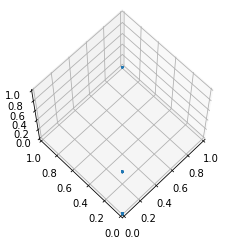

In [68]:
# create figure #
ml_figure = plt.figure()

# create figure sub-plot #
ml_plot = ml_figure.add_subplot(111, projection='3d' )

# create scatter plot : s=8 for w=64, s=24 for w=32 #
ml_plot.scatter(Y[:,0], Y[:,1], Y[:,2], s=8, marker='.')#, edgecolor='none', cmap='inferno', vmin=0.0, vmax=1.25 )

# setting axis aspect ratio #
ml_plot.set_aspect( 'equal' )

# setting axis limits #
ml_plot.set_xlim( 0.0, 1.0 )
ml_plot.set_ylim( 0.0, 1.0 )
ml_plot.set_zlim( 0.0, 1.0 )

# setting plot initial camera view #
ml_plot.view_init( elev=66, azim=225 )